In [1]:
# importing dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display

In [64]:
#loading csv file
data = pd.read_csv('game_teams_stats.csv')
display(data.head())

,game_id,team_id,HoA,won,settled_in,head_coach,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2012030221,3,away,False,OT,John Tortorella,2,35,44,8,3,0,44.8,17,7
1,2012030221,6,home,True,OT,Claude Julien,3,48,51,6,4,1,55.2,4,5
2,2012030222,3,away,False,REG,John Tortorella,2,37,33,11,5,0,51.7,1,4
3,2012030222,6,home,True,REG,Claude Julien,5,32,36,19,1,0,48.3,16,6
4,2012030223,6,away,True,REG,Claude Julien,2,34,28,6,0,0,61.8,10,7


In [65]:
data.columns

Index(['game_id', 'team_id', 'HoA', 'won', 'settled_in', 'head_coach', 'goals',
       'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals',
       'faceOffWinPercentage', 'giveaways', 'takeaways'],
      dtype='object')

In [66]:
data.info

<bound method DataFrame.info of           game_id  team_id   HoA    won settled_in        head_coach  goals  \
0      2012030221        3  away  False         OT   John Tortorella      2   
1      2012030221        6  home   True         OT     Claude Julien      3   
2      2012030222        3  away  False        REG   John Tortorella      2   
3      2012030222        6  home   True        REG     Claude Julien      5   
4      2012030223        6  away   True        REG     Claude Julien      2   
5      2012030223        3  home  False        REG   John Tortorella      1   
6      2012030224        6  away  False         OT     Claude Julien      3   
7      2012030224        3  home   True         OT   John Tortorella      4   
8      2012030225        3  away  False        REG   John Tortorella      1   
9      2012030225        6  home   True        REG     Claude Julien      3   
10     2012030311        6  away   True        REG     Claude Julien      3   
11     2012030311   

In [67]:
data.shape

(14882, 15)

In [68]:
data.dropna(how ='any').shape

(14882, 15)

In [69]:
data = data.drop(data.columns[5], axis=1)
display(data.head())

,game_id,team_id,HoA,won,settled_in,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways
0,2012030221,3,away,False,OT,2,35,44,8,3,0,44.8,17,7
1,2012030221,6,home,True,OT,3,48,51,6,4,1,55.2,4,5
2,2012030222,3,away,False,REG,2,37,33,11,5,0,51.7,1,4
3,2012030222,6,home,True,REG,5,32,36,19,1,0,48.3,16,6
4,2012030223,6,away,True,REG,2,34,28,6,0,0,61.8,10,7


In [70]:
#one-hot encoding for HoA column, away=0, home=1
HoA_dummy = pd.get_dummies(data['HoA'],prefix = 'Game')
data = pd.concat([data,HoA_dummy],axis=1)

data = data.drop(['HoA'],1)

In [71]:
display(data.head())

,game_id,team_id,won,settled_in,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,Game_away,Game_home
0,2012030221,3,False,OT,2,35,44,8,3,0,44.8,17,7,1,0
1,2012030221,6,True,OT,3,48,51,6,4,1,55.2,4,5,0,1
2,2012030222,3,False,REG,2,37,33,11,5,0,51.7,1,4,1,0
3,2012030222,6,True,REG,5,32,36,19,1,0,48.3,16,6,0,1
4,2012030223,6,True,REG,2,34,28,6,0,0,61.8,10,7,1,0


In [72]:
#one-hot encoding for settled_in column
Settled_dummy = pd.get_dummies(data['settled_in'],prefix = 'Game')
data = pd.concat([data, Settled_dummy],axis=1)

data = data.drop(['settled_in'],1)

In [73]:
display(data.head())

,game_id,team_id,won,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,Game_away,Game_home,Game_OT,Game_REG,Game_SO
0,2012030221,3,False,2,35,44,8,3,0,44.8,17,7,1,0,1,0,0
1,2012030221,6,True,3,48,51,6,4,1,55.2,4,5,0,1,1,0,0
2,2012030222,3,False,2,37,33,11,5,0,51.7,1,4,1,0,0,1,0
3,2012030222,6,True,5,32,36,19,1,0,48.3,16,6,0,1,0,1,0
4,2012030223,6,True,2,34,28,6,0,0,61.8,10,7,1,0,0,1,0


In [74]:
#one-hot encoding for won column
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

data['won'] = lb.fit_transform(data["won"])

In [75]:
display(data.head())

,game_id,team_id,won,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,Game_away,Game_home,Game_OT,Game_REG,Game_SO
0,2012030221,3,0,2,35,44,8,3,0,44.8,17,7,1,0,1,0,0
1,2012030221,6,1,3,48,51,6,4,1,55.2,4,5,0,1,1,0,0
2,2012030222,3,0,2,37,33,11,5,0,51.7,1,4,1,0,0,1,0
3,2012030222,6,1,5,32,36,19,1,0,48.3,16,6,0,1,0,1,0
4,2012030223,6,1,2,34,28,6,0,0,61.8,10,7,1,0,0,1,0


In [76]:
data.columns

Index(['game_id', 'team_id', 'won', 'goals', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',
       'giveaways', 'takeaways', 'Game_away', 'Game_home', 'Game_OT',
       'Game_REG', 'Game_SO'],
      dtype='object')

In [77]:
#what is the winning rate for the home team?

# Total number of matches.
no_indices = data.shape[0]
no_matches = no_indices

# # Calculate number of features. -1 because we are saving one as the target variable (win/lose)
no_features = data.shape[1] - 1

# Calculate matches won by home team.
no_homewins = len(data[(data['won']==1)==(data['Game_home']==1)])

# # Calculate win rate for home team.
winning_rate = (float(no_homewins) / (no_matches)) * 100

# Print the results
print ("Total number of matches: {}".format(no_matches))
print ("Number of features: {}".format(no_features))
print ("Number of matches won by home team: {}".format(no_homewins))
print ("Winning rate for home team: {:.2f}".format(winning_rate))

Total number of matches: 14882
Number of features: 16
Number of matches won by home team: 8178
Winning rate for home team: 54.95


In [78]:
data.columns

Index(['game_id', 'team_id', 'won', 'goals', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',
       'giveaways', 'takeaways', 'Game_away', 'Game_home', 'Game_OT',
       'Game_REG', 'Game_SO'],
      dtype='object')

'scatter_matrix_plot'

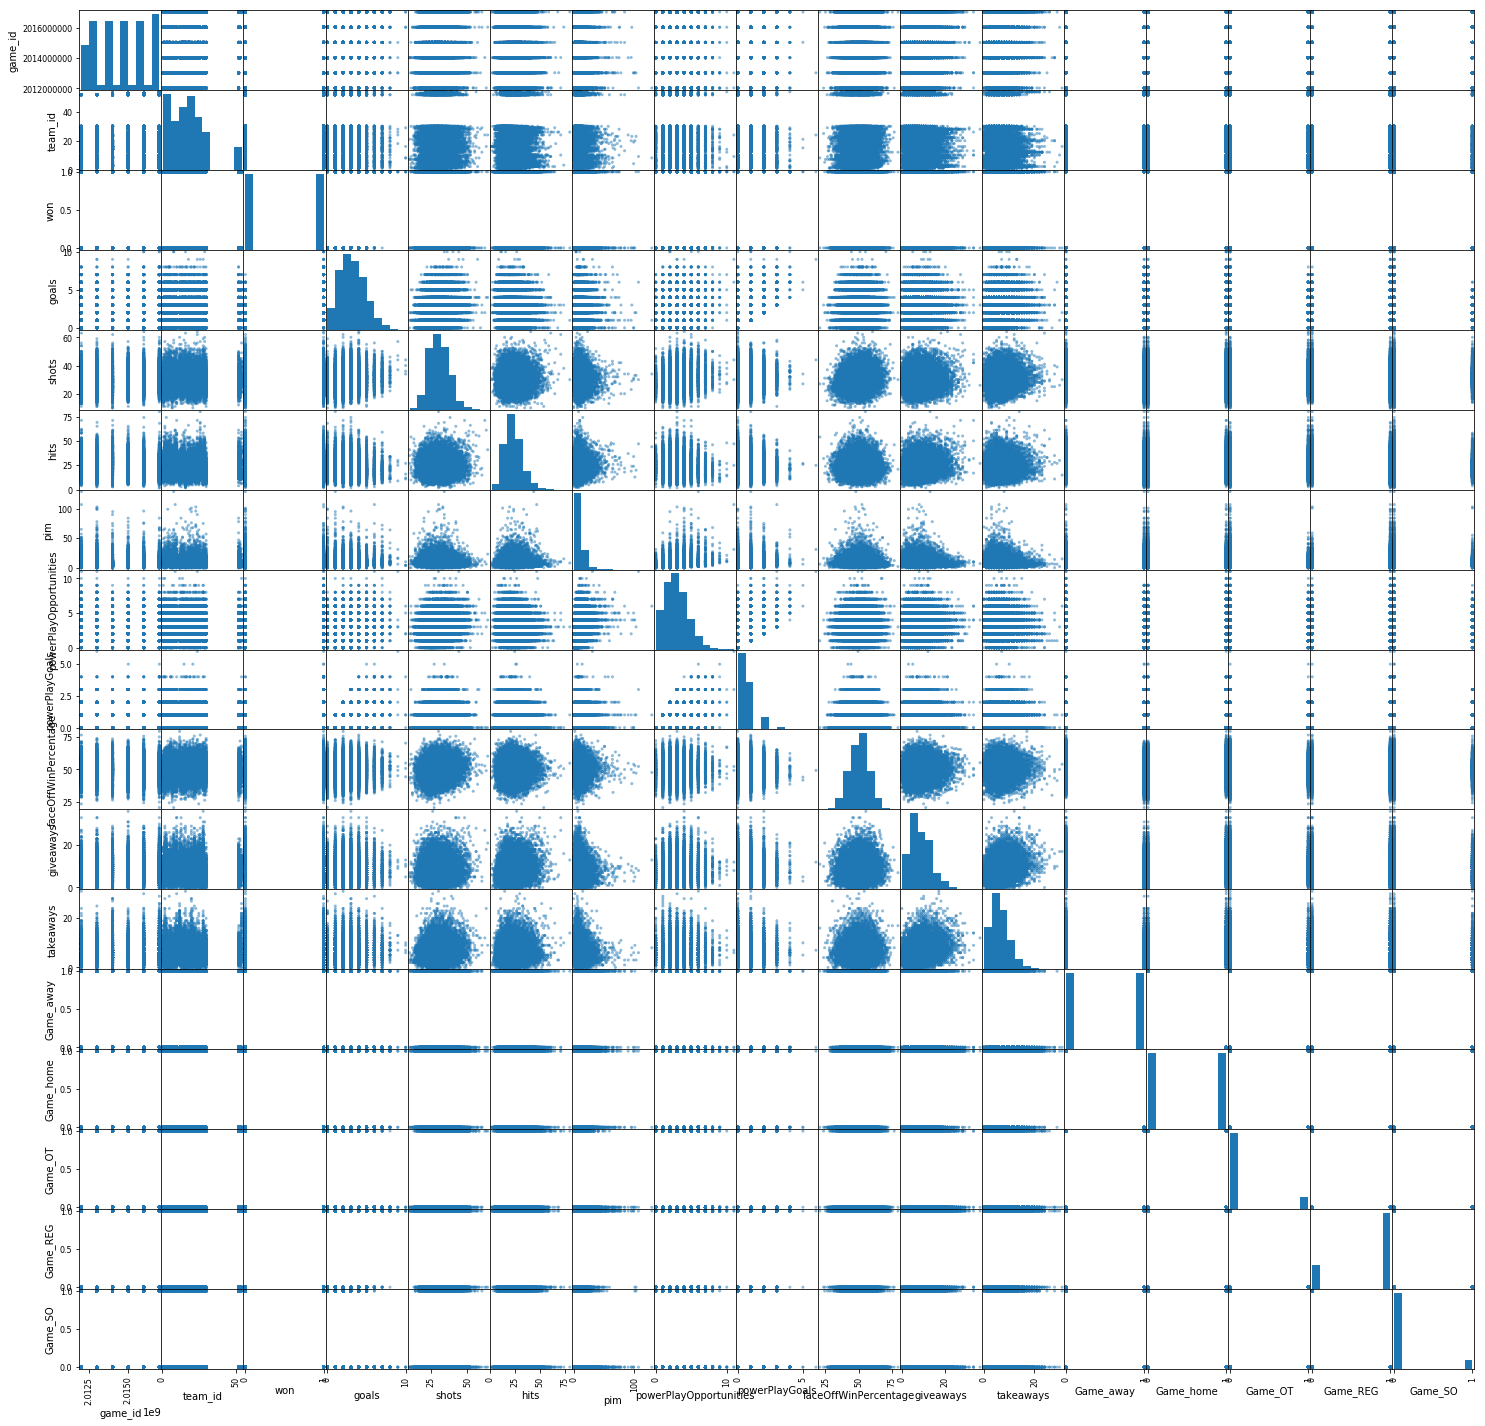

In [79]:
#Scatterplot matrix to determine correlation between each attributes against one another
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

attributes = ["game_id", "team_id", "won", "goals", "shots", "hits", "pim",
       "powerPlayOpportunities", "powerPlayGoals", "faceOffWinPercentage",
       "giveaways", "takeaways", "Game_away", "Game_home", "Game_OT",
       "Game_REG", "Game_SO"]
scatter_matrix(data[attributes], figsize=(25, 25))
("scatter_matrix_plot")

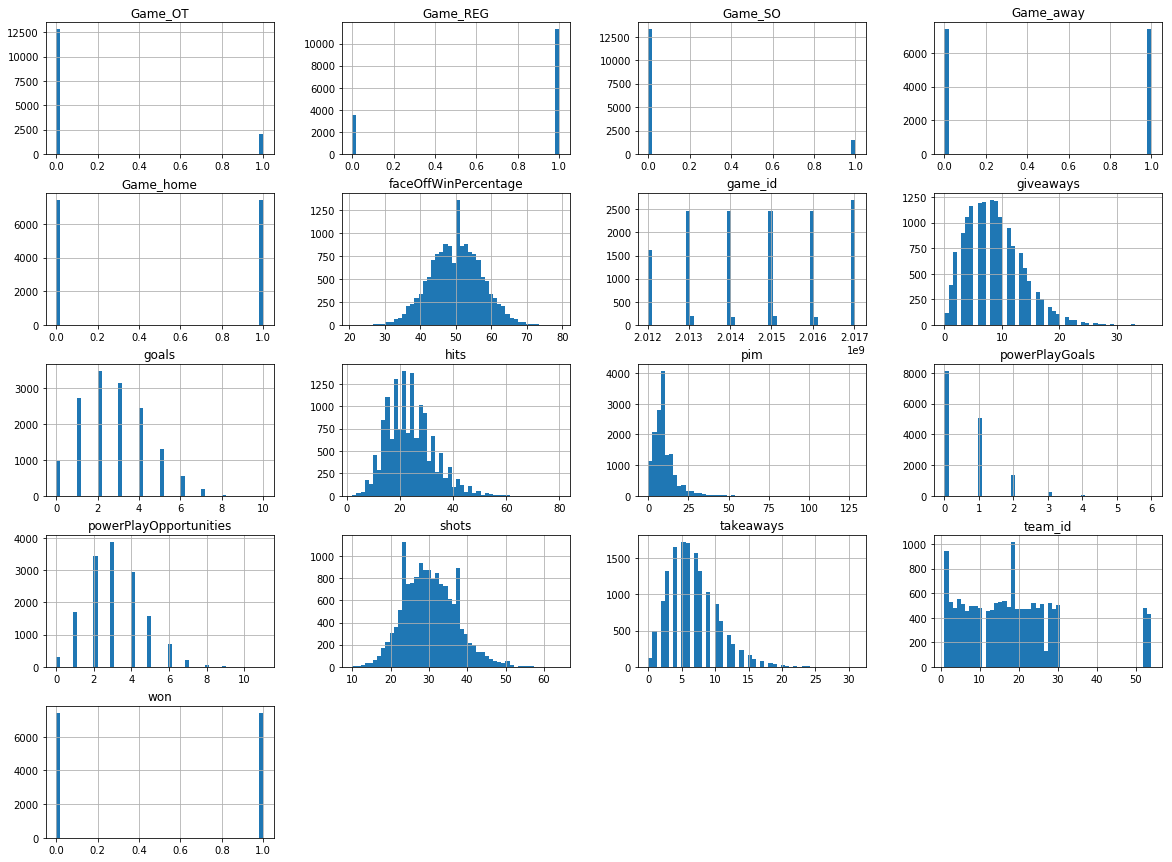

In [80]:
#barplots for each attributes
data.hist(bins=50, figsize=(20,15))
("attribute_histogram_plots")
plt.show()

In [81]:
data.shape

(14882, 17)

In [82]:
data.columns

Index(['game_id', 'team_id', 'won', 'goals', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',
       'giveaways', 'takeaways', 'Game_away', 'Game_home', 'Game_OT',
       'Game_REG', 'Game_SO'],
      dtype='object')

In [83]:
#converting csv to pandas dataframe
df=pd.DataFrame(data, columns=['game_id', 'team_id', 'won', 'goals', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',
       'giveaways', 'takeaways', 'Game_away', 'Game_home', 'Game_OT',
       'Game_REG', 'Game_SO'])
df.head(5)

,game_id,team_id,won,goals,shots,hits,pim,powerPlayOpportunities,powerPlayGoals,faceOffWinPercentage,giveaways,takeaways,Game_away,Game_home,Game_OT,Game_REG,Game_SO
0,2012030221,3,0,2,35,44,8,3,0,44.8,17,7,1,0,1,0,0
1,2012030221,6,1,3,48,51,6,4,1,55.2,4,5,0,1,1,0,0
2,2012030222,3,0,2,37,33,11,5,0,51.7,1,4,1,0,0,1,0
3,2012030222,6,1,5,32,36,19,1,0,48.3,16,6,0,1,0,1,0
4,2012030223,6,1,2,34,28,6,0,0,61.8,10,7,1,0,0,1,0


In [84]:
#"StandardScaler helps standardize the dataset’s features"
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(df)


C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [85]:
#"Principal component analysis is a fast and flexible ML methods for dimensionality reduction in data"
from sklearn.decomposition import PCA 

pca = PCA(n_components=2)
pca.fit(df)
dm_reductions = [pca]  
dm_reductions

[PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False)]

In [86]:
df_pca=pca.transform(df)

In [87]:
df_pca.shape

(14882, 2)

Text(0, 0.5, 'Second principle component')

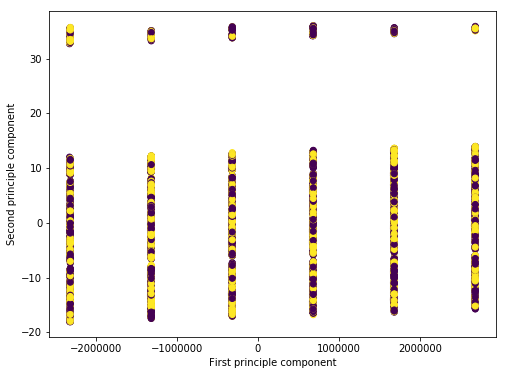

In [88]:
#" plot the first two principal components of each point to learn about the data:""
plt.figure(figsize=(8,6))
plt.scatter(df_pca[:,0], df_pca[:,1], c=data['won'])
plt.xlabel('First principle component')
plt.ylabel('Second principle component')

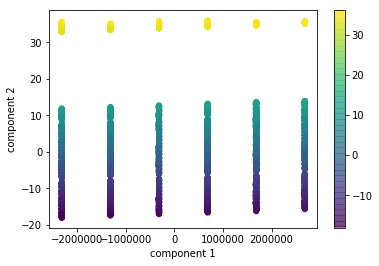

In [89]:
#" plot the first two principal components of each point to learn about the data:"
import matplotlib.pyplot as plt


plt.scatter(df_pca[:,0], df_pca[:,1],
            c=df_pca[:,1], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

In [90]:
# to make this notebook's output identical at every run
np.random.seed(42)


In [91]:
# Separate into feature set and target variable
#ATW_cat (0=Away team lost,1=away team won,2=home team lost,3=home team won)
X_all = data.drop(['won'],1)
y_all = data['won']

In [92]:
data.columns

Index(['game_id', 'team_id', 'won', 'goals', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',
       'giveaways', 'takeaways', 'Game_away', 'Game_home', 'Game_OT',
       'Game_REG', 'Game_SO'],
      dtype='object')

In [93]:
# Standardising the data 
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['game_id', 'team_id', 'goals', 'shots', 'hits', 'pim',
       'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage',
       'giveaways', 'takeaways', 'Game_away', 'Game_home', 'Game_OT',
       'Game_REG', 'Game_SO']]
for col in cols:
    X_all[col] = scale(X_all[col])

C:\Users\Owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Owner\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [94]:
def preprocess_features(X):
    ''' Preprocesses the nhl data and converts catagorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns (16 total features):
['game_id', 'team_id', 'goals', 'shots', 'hits', 'pim', 'powerPlayOpportunities', 'powerPlayGoals', 'faceOffWinPercentage', 'giveaways', 'takeaways', 'Game_away', 'Game_home', 'Game_OT', 'Game_REG', 'Game_SO']


In [95]:
# Shuffle and split the dataset into training and testing set.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 2976,
                                                    random_state = 2,
                                                    stratify = y_all)

In [96]:
# Fit on training set only.
scaler.fit(X_train, y_train,)
# Apply transform to both the training set and the test set.
Xtrain_pca = scaler.transform(X_train)
Xtest_pca = scaler.transform(X_test)

In [97]:
pca.fit(Xtrain_pca)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [98]:
#pca transformation on data
Xtrain_pca = pca.transform(Xtrain_pca)
Xtest_pca = pca.transform(Xtest_pca)

In [99]:
#training the model with pca transformed data
#for measuring training time
from time import time 

# "F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0".
from sklearn.metrics import f1_score

def train_classifier1(clf, Xtrain_pca, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(Xtrain_pca, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels1(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label=1), sum(target == y_pred) / float(len(y_pred))


def train_predict1(clf, Xtrain_pca, y_train, Xtest_pca, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(Xtrain_pca)))
    
    # Train the classifier
    train_classifier1(clf, Xtrain_pca, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels1(clf, Xtrain_pca, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels1(clf, Xtest_pca, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    
  

In [100]:
#Running the model with pca transformed data
# Initialize the three models (XGBoost is initialized later)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

clf_A = LogisticRegression(solver='lbfgs',random_state = 42)
clf_B = SVC(gamma= 'auto',random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)
clf_D = RandomForestClassifier(n_estimators=10)
clf_E = AdaBoostClassifier(n_estimators=100)


train_predict1(clf_A,  Xtrain_pca, y_train, Xtest_pca, y_test)
print ('')
train_predict1(clf_B,  Xtrain_pca, y_train, Xtest_pca, y_test)
print ('')
train_predict1(clf_C,  Xtrain_pca, y_train, Xtest_pca, y_test)
print ('')
train_predict1(clf_D,  Xtrain_pca, y_train, Xtest_pca, y_test)
print ('')
train_predict1(clf_E,  Xtrain_pca, y_train, Xtest_pca, y_test)
print ('')

Training a LogisticRegression using a training set size of 11906. . .
Trained model in 0.0092 seconds
Made predictions in 0.0000 seconds.
0.5585382750259785 0.5718125314967243
F1 score and accuracy score for training set: 0.5585 , 0.5718.
Made predictions in 0.0000 seconds.
F1 score and accuracy score for test set: 0.5676 , 0.5843.

Training a SVC using a training set size of 11906. . .
Trained model in 8.2686 seconds
Made predictions in 3.1535 seconds.
0.6406101048617732 0.6516882244246598
F1 score and accuracy score for training set: 0.6406 , 0.6517.
Made predictions in 0.8482 seconds.
F1 score and accuracy score for test set: 0.6275 , 0.6438.

Training a XGBClassifier using a training set size of 11906. . .
Trained model in 0.5621 seconds
Made predictions in 0.0643 seconds.
0.6655373930719064 0.6683184948765328
F1 score and accuracy score for training set: 0.6655 , 0.6683.
Made predictions in 0.0191 seconds.
F1 score and accuracy score for test set: 0.6372 , 0.6442.

Training a Rand

In [101]:
#training the model with pca transformed data
#for measuring training time
from time import time 

# "F1 score (also F-score or F-measure) is a measure of a test's accuracy. 
#It considers both the precision p and the recall r of the test to compute 
#the score: p is the number of correct positive results divided by the number of 
#all positive results, and r is the number of correct positive results divided by 
#the number of positive results that should have been returned. The F1 score can be 
#interpreted as a weighted average of the precision and recall, where an F1 score 
#reaches its best value at 1 and worst at 0".
from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    # Print and return results
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, pos_label=1), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))
    
  

In [102]:
#Running the model with pca transformed data
# Initialize the three models (XGBoost is initialized later)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

clf_A = LogisticRegression(solver='lbfgs',random_state = 42)
clf_B = SVC(gamma= 'auto',random_state = 912, kernel='rbf')
#Boosting refers to this general problem of producing a very accurate prediction rule 
#by combining rough and moderately inaccurate rules-of-thumb
clf_C = xgb.XGBClassifier(seed = 82)
clf_D = RandomForestClassifier(n_estimators=10)
clf_E = AdaBoostClassifier(n_estimators=100)


train_predict(clf_A, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_B, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_C, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_D, X_train, y_train, X_test, y_test)
print ('')
train_predict(clf_E, X_train, y_train, X_test, y_test)
print ('')

Training a LogisticRegression using a training set size of 11906. . .
Trained model in 0.0206 seconds
Made predictions in 0.0010 seconds.
0.7784724569111188 0.7797749034100454
F1 score and accuracy score for training set: 0.7785 , 0.7798.
Made predictions in 0.0000 seconds.
F1 score and accuracy score for test set: 0.7672 , 0.7675.

Training a SVC using a training set size of 11906. . .
Trained model in 8.7849 seconds
Made predictions in 4.6830 seconds.
0.8203248646397333 0.8188308415924744
F1 score and accuracy score for training set: 0.8203 , 0.8188.
Made predictions in 1.1101 seconds.
F1 score and accuracy score for test set: 0.7700 , 0.7658.

Training a XGBClassifier using a training set size of 11906. . .
Trained model in 0.9419 seconds
Made predictions in 0.0799 seconds.
0.7973845251068824 0.7969931127162775
F1 score and accuracy score for training set: 0.7974 , 0.7970.
Made predictions in 0.0240 seconds.
F1 score and accuracy score for test set: 0.7606 , 0.7584.

Training a Rand

In [103]:
#Parameters tuning of XGBoost.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer


# "TODO: Create the parameters list you wish to tune
parameters = { 'learning_rate' : [0.1],
               'n_estimators' : [80],
               'max_depth': [1],
               'min_child_weight': [1],
               'gamma':[0.6],
               'subsample' : [.6],
               'colsample_bytree' : [0.6],
               'scale_pos_weight' : [1],
               'reg_alpha':[1e-5]
             }  

# TODO: Initialize the classifier
clf = xgb.XGBClassifier(seed=82)

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,pos_label=1)

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf,
                        scoring=f1_scorer,
                        param_grid=parameters,
                        cv=5)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train,y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print (clf)

# Report the final F1 score for training and testing after parameter tuning"
f1, acc = predict_labels(clf, X_train, y_train)
print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
    
f1, acc = predict_labels(clf, X_test, y_test)
print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0.6, learning_rate=0.1,
       max_delta_step=0, max_depth=1, min_child_weight=1, missing=None,
       n_estimators=80, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=1e-05,
       reg_lambda=1, scale_pos_weight=1, seed=82, silent=True,
       subsample=0.6)
Made predictions in 0.0249 seconds.
F1 score and accuracy score for training set: 0.7777 , 0.7747.
Made predictions in 0.0120 seconds.
F1 score and accuracy score for test set: 0.7702 , 0.7655.


In [104]:
#"Applying K-fold to obtaiin more accurate estimate of out-of-sample accuracy
#More "efficient" use of data"
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False).split(range(14882))

# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(kf, start=1):
    print('{:^9} {} {:^25}'.format(iteration, data[0], str(data[1])))

Iteration                   Training set observations                   Testing set observations
    1     [ 2977  2978  2979 ... 14879 14880 14881] [   0    1    2 ... 2974 2975 2976]
    2     [    0     1     2 ... 14879 14880 14881] [2977 2978 2979 ... 5951 5952 5953]
    3     [    0     1     2 ... 14879 14880 14881] [5954 5955 5956 ... 8927 8928 8929]
    4     [    0     1     2 ... 14879 14880 14881] [ 8930  8931  8932 ... 11903 11904 11905]
    5     [    0     1     2 ... 11903 11904 11905] [11906 11907 11908 ... 14879 14880 14881]


In [110]:
from sklearn.model_selection import cross_val_score
import seaborn as sns


# 10-fold cross-validation for all the models
clf_A = LogisticRegression(solver='lbfgs',random_state = 42)
scores = cross_val_score(clf_A, X_all, y_all, cv=10, scoring='accuracy')
print("10-fold cross-validation for LogisticRegression\n ")
print(scores)
print("\n")
print("mean score of cross-validation for LogisticRegression\n ")
print(scores.mean())
print("\n")



clf_B = SVC(gamma='auto', random_state = 912, kernel='rbf')
scores = cross_val_score(clf_B, X_all, y_all, cv=10, scoring='accuracy')
print("10-fold cross-validation for SVC\n ")
print(scores)
print("\n")
print("mean score of cross-validation for SVC\n ")
print(scores.mean())
print("\n")


clf_C = xgb.XGBClassifier(seed = 82)
scores = cross_val_score(clf_C, X_all, y_all, cv=10, scoring='accuracy')
print("10-fold cross-validation for XGBClassifier\n ")
print(scores)
print("\n")
print("mean score of cross-validation for XGBClassifier\n ")
print(scores.mean())
print("\n")


clf_D = RandomForestClassifier(n_estimators=10)
scores = cross_val_score(clf_D, X_all, y_all, cv=10, scoring='accuracy')
print("10-fold cross-validation for RandomForestClassifier\n ")
print(scores)
print("\n")
print("mean score cross-validation for RandomForestClassifier\n ")
print(scores.mean())
print("\n")


clf_E = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf_E, X_all, y_all, cv=10, scoring='accuracy')
print("10-fold cross-validation for AdaBoostClassifier\n ")
print(scores)
print("\n")
print("mean score cross-validation for AdaBoostClassifier\n ")
print(scores.mean())
print("\n")



10-fold cross-validation for LogisticRegression
 
[0.76912752 0.77620968 0.79032258 0.76344086 0.77150538 0.77553763
 0.78427419 0.77755376 0.77822581 0.78897849]


mean score of cross-validation for LogisticRegression
 
0.7775175903875298


10-fold cross-validation for SVC
 
[0.76308725 0.77620968 0.77889785 0.76008065 0.76008065 0.78360215
 0.78629032 0.78427419 0.7688172  0.79502688]


mean score of cross-validation for SVC
 
0.7756366818214621


10-fold cross-validation for XGBClassifier
 
[0.76912752 0.78561828 0.78763441 0.7641129  0.77688172 0.77553763
 0.77822581 0.78293011 0.77889785 0.78293011]


mean score of cross-validation for XGBClassifier
 
0.7781896333982825


10-fold cross-validation for RandomForestClassifier
 
[0.73825503 0.76008065 0.7594086  0.75604839 0.75537634 0.73051075
 0.76075269 0.7594086  0.75873656 0.76612903]


mean score cross-validation for RandomForestClassifier
 
0.7544706646460273


10-fold cross-validation for AdaBoostClassifier
 
[0.76107383 0.780